In [ ]:
# !pip install gsdmm
!pip install pymorphy2
!pip install pyLDAvis

from google.colab import drive
import pandas as pd
import pymorphy2
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from gensim import corpora
from gensim.models import LdaModel
from gensim.matutils import Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

from gensim.models import CoherenceModel
from gensim.corpora import Dictionary


drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 854.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=b00899463e94500021b3422a1cabd7420bf09df910ddb7e30ecf30251ac6b9ac
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 376.1/376.1 kB 16.9 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cpu')

## Считываем данные

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/voice_bot_26_03_2024.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Предобработка текста


In [ ]:
print(df.shape)
print(df.head(10))
print(df.datetime.max())
print(df.datetime.min())

(1699393, 3)
    id                                               text  \
0    2                                получение куар хода   
1   20                      потеряли код получения заказа   
2   36                                   получить посылку   
3   50            мне не пришел код для получения посылки   
4   64                             связаться с оператором   
5   72                я хочу узнать код получения посылки   
6   88                          оператора можно связаться   
7   96               мне пришла смска от получения заказа   
8  112             а не могу забрать посылку из постамата   
9  120  алло здравствуйте а можно мне смску чтобы полу...   

                     datetime  
0  2022-01-25 10:26:08.250148  
1  2022-01-25 11:15:12.752175  
2  2022-01-25 12:06:13.747782  
3  2022-01-25 14:19:56.151572  
4  2022-01-25 14:41:44.752494  
5  2022-01-25 15:40:12.343129  
6  2022-01-25 16:37:29.556679  
7  2022-01-25 18:51:15.046167  
8  2022-01-25 19:26:38.7436

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
morph = pymorphy2.MorphAnalyzer()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Py

In [ ]:
import string
def preprocess_text(data, stopwords=stopwords.words('russian')):
  """ Очистка текста и удаление стоп слов """
  text = re.sub('ё', 'е', data[0])
  text = ''.join([char for char in text if char not in string.punctuation])  # Удаление знаков препинания
  text = ' '.join(text.split())  # Удаление повторяющихся пробелов
  text = text.strip()
  # удаление стоп слов
  text = [w for w in text.split() if w.lower() not in stopwords]
  # удаление слов короче 3 символов
  text  = [w for w in text if len(w) >=3]
  return [' '.join(text)]

def lemmatization_text(data, morph=morph):
  """ Приведение слов к нормальной форме """

  result = ' '.join([morph.parse(x)[0].normal_form for x in data])
  result = ' '.join([x for x in result.split()])
  return result

def get_results(data, morph=morph, stopwords=stopwords.words('russian')):
  """ Очистка текста и удаление стоп слов, приведение слов к нормальной форме
  и токенизация """

  if data is not np.NaN:
    result = preprocess_text(data=data)
    result = lemmatization_text(result)
    return result
  return ''


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Очистка текста

In [ ]:
def transform_data(data: pd.Series) -> list:
  transorm_lst=[get_results(data=[i]) for i in data]
  transorm_lst=[x for x in transorm_lst if x not in [None, '']]
  return transorm_lst

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## обработка датаеста

# Capture the start time
start_time = time.time()

X_train, X_test = train_test_split(df['text'],
                                   test_size=0.0001,
                                   random_state=10
                                  )

test_lst = transform_data(X_train)

# Capture the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"The script took {elapsed_time} seconds to run.")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The script took 373.3990957736969 seconds to run.


In [ ]:
print(len(test_lst))
print(test_lst[6])

1655929
заказ


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
vector_ben = CountVectorizer(
    analyzer='word',
    min_df=75,
    ngram_range=(1,3),
    stop_words=stopwords.words('russian')
    )
test_vec_ben = vector_ben.fit_transform(test_lst)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## BaseLine LDA

In [ ]:
# Capture the start time
start_time = time.time()


# Convert document-term matrix to a Gensim-friendly format
corpus = Sparse2Corpus(test_vec_ben , documents_columns=False)

# Create dictionary mapping for Gensim
id2word = corpora.Dictionary.from_corpus(corpus, id2word=dict((id, word) for word, id in vector_ben.vocabulary_.items()))

# Perform LDA using Gensim
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)


# Capture the end time
end_time = time.time()
# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"The script took {elapsed_time} seconds to run.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
pannel = pyLDAvis.gensim_models.prepare(lda_model,
                                        corpus,
                                        id2word,
                                        mds='tsne'
                                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pannel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1      14.261856 -73.563354       1        1  32.311481
2      43.724983  16.129807       2        1  26.526075
0     -46.390301  43.981197       3        1  23.360264
3     -75.836456 -45.801773       4        1  17.802180, topic_info=           Term           Freq          Total Category  logprob  loglift
10     оператор  305954.000000  305954.000000  Default  30.0000  30.0000
2         заказ  427284.000000  427284.000000  Default  29.0000  29.0000
29          код  404030.000000  404030.000000  Default  28.0000  28.0000
30       выдача  317688.000000  317688.000000  Default  27.0000  27.0000
32   код выдача  291002.000000  291002.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
7      постамат   26034.807400   49902.711790   Topic4  -4.0696   1.0752
215  пожалуйста   13160.524400   21732.544386   Topic4  -4.7519   1.2243
172    продлить   14060.990595   26402.062919   Topic4  -4.6857   1.0958
36      забрать   12704.730433   31405.514070   Topic4  -4.7871   0.8208
63         срок    7971.243729   22968.242178   Topic4  -5.2532   0.6676

[192 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1356      2  0.670657  абонент
1356      3  0.060379  абонент
1356      4  0.268884  абонент
332       4  0.999962  автомат
478       1  0.999963    адрес
...     ...       ...      ...
614       1  0.999931   четыре
740       1  0.999926    шесть
58        1  0.999940      это
191       4  0.999992   ячейка
178       3  0.999882     ящик

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

## Когерентность

In [ ]:
def get_coherence_mean(model, texts, n_top_words=20):
  # кол-во тем
  topics = []
  for i in range(model.num_topics):
    if i == 0:
      topics .append(1)
    else:
      topics .append(i+1)
  topics = np.array(topics)
  # получение токенов
  text =  [[word for word in doc.split()] for doc in texts]
  # создание словаря с использованием gensim
  dictinoary = corpora.Dictionary(text)
  # корпус на основе матрицы подсчета слов
  corpus = [dictinoary.doc2bow(text) for text in text]
  feature_names = [dictinoary[i] for i in range(len(dictinoary))]

  # получение топ-слов для каждой темы
  top_words = []
  for topic in topics:
    top_words.append(
        [feature_names[i] for i in topics.argsort()[:-20 -1: -1]])
  print(top_words[0])

  coherence_model = CoherenceModel(topics=top_words,
                                  texts=text,
                                  dictionary=dictinoary,
                                  coherence='c_v')
  coherence = coherence_model.get_coherence()
  return coherence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
get_coherence_mean(lda_model, test_lst)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['постамат', 'узнать', 'статус', 'заказ']


0.615755848139168

## Анализ тем и разметка данных

In [ ]:
def predict_topics(data, vectorizer=vector_ben, model=lda_model):
  # transform_text = get_results(data.tolist())
  dt = data.tolist()
  transform_text = [get_results([i]) for i in dt]
  vec_text = vectorizer.transform(transform_text)
  corpus = Sparse2Corpus(vec_text , documents_columns=False)
  topic_proba = lda_model.get_document_topics(corpus)
  return topic_proba
  # if not topic_proba:
  #   return -9
  # return max(topic_proba[1], key=lambda x: x[1])[0]+1


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_topics = X_train.copy()
topics = predict_topics(df_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_topics = X_train.copy()
print(len(topics)==df_topics.shape[0])
print(len(topics))
print(df_topics.shape)


True
84969
(84969,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
topics_prob = []
for i in topics:
  top = max(i, key=lambda x: x[1])[0]+1
  topics_prob.append(top)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
assigned_df = pd.DataFrame(df_topics).assign(topic=topics_prob)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
assigned_df.head(20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,topic
866871,да,1
1341780,я тебя не слышу,1
1528403,получить код доступа,2
314333,получить код выдачи,4
1659044,узнать статус заказа,1
440580,так не могу получить товар,3
1107957,получить код выдачи,4
938065,мне надо узнать статус заказа который возврати...,3
1462859,статус заказа,1
15801,я не могу получить посылку в банкомате,3


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='new_column', ylabel='count'>

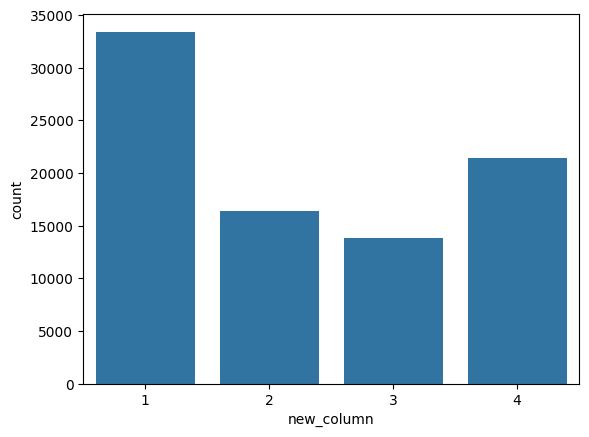

In [ ]:
import seaborn as sns
sns.countplot(x='new_column', data=new_df)